In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer
from sklearn.model_selection import GridSearchCV
import shap

In [2]:
dataset = pd.read_csv(r'incident_gas_distribution_jan2010_present.csv')
dataset.head()

,REPORT_RECEIVED_DATE,IYEAR,REPORT_NUMBER,SUPPLEMENTAL_NUMBER,REPORT_TYPE,OPERATOR_ID,NAME,OPERATOR_STREET_ADDRESS,OPERATOR_CITY_NAME,OPERATOR_STATE_ABBREVIATION,...,PREPARER_TELEPHONE,PREPARER_FAX,LOCAL_CONTACT_NAME,LOCAL_CONTACT_EMAIL,LOCAL_CONTACT_TELEPHONE,AUTHORIZER_NAME,AUTHORIZER_TITLE,AUTHORIZER_TELEPHONE,AUTHORIZER_EMAIL,NARRATIVE
0,11/17/21,2021,20210096,36009,ORIGINAL,22364,WEST BATON ROUGE PARISH NATURAL GAS SYSTEM,"880 N ALEXANDER, P.O. BOX 807",PORT ALLEN,LA,...,2253362406,2253875352,ADRIAN GENRE,adrian.genre@wbrcouncil.org,2253362406,ADRIAN GENRE,DIRECTOR OF UTILITIES,2253362406,adrian.genre@wbrcouncil.org,GAS CREW WAS INSTALLING A NEW 3/4 INCH PE SERV...
1,11/23/21,2021,20210098,36039,ORIGINAL FINAL,31232,AVISTA CORP,"1411 EAST MISSION (PO BOX 3727, 99220-3727)",SPOKANE,WA,...,509-495-2162,NaN,JOSH FORT,josh.fort@avistacorp.com,509-495-2656,VERN MALENSKY,MANAGER NATURAL GAS INTEGRITY AND COMPLIANCE,509-495-2706,vern.malensky@avistacorp.com,"AT APPROXIMATELY 10:00 A.M. PDT ON OCTOBER 28,..."
2,11/24/21,2021,20210099,36045,ORIGINAL FINAL,13710,NORTHERN ILLINOIS GAS CO,"P.O. BOX 190, RT 59 & I-88",AURORA,IL,...,NaN,NaN,NaN,NaN,NaN,LETICIA QUEZADA,DIRECTOR COMPLIANCE AND QA,6305142036,lquezad@southernco.com,"ON THE DATE OF THE INCIDENT, THERE WERE THUNDE..."
3,11/16/21,2021,20210095,36005,ORIGINAL FINAL,1720,"BRENHAM UTILITY, CITY OF",210 NORTH PARK STREET,BRENHAM,TX,...,19793377416,19793377419,ANDE BOSTAIN,abostain@cityofbrenham.org,19794511772,ANDE BOSTAIN,GAS SUPERINTINDENT,19794511772,abostain@cityofbrenham.org,THE EXCAVATOR WAS WORKING ON THE ACCESS ROAD F...
4,11/19/21,2021,20210097,36025,ORIGINAL,2392,CITIZENS GAS & COKE UTILITY,2020 NORTH MERIDAN ST,INDIANAPOLIS,IN,...,3176912514,NaN,NaN,NaN,NaN,BENJAMIN S. WARREN,DIRECTOR GAS TRANSMISSION AND DISTRIBUTION,3176912514,bwarren@citizensenergygroup.com,THE FINDINGS OF THE INVESTIGATION BY THE FIRE ...


In [3]:
dataset.columns

Index(['REPORT_RECEIVED_DATE', 'IYEAR', 'REPORT_NUMBER', 'SUPPLEMENTAL_NUMBER',
       'REPORT_TYPE', 'OPERATOR_ID', 'NAME', 'OPERATOR_STREET_ADDRESS',
       'OPERATOR_CITY_NAME', 'OPERATOR_STATE_ABBREVIATION',
       ...
       'PREPARER_TELEPHONE', 'PREPARER_FAX', 'LOCAL_CONTACT_NAME',
       'LOCAL_CONTACT_EMAIL', 'LOCAL_CONTACT_TELEPHONE', 'AUTHORIZER_NAME',
       'AUTHORIZER_TITLE', 'AUTHORIZER_TELEPHONE', 'AUTHORIZER_EMAIL',
       'NARRATIVE'],
      dtype='object', length=466)

In [4]:
X = dataset[['COMMODITY_RELEASED_TYPE', 'ACCIDENT_IDENTIFIER','FLOW_CONT_KEY_CRIT_IND', 'FLOW_CONT_MAIN_VALVE_IND','FLOW_CONT_SERVICE_VALVE_IND','FLOW_CONT_METER_REG_IND','FLOW_CONT_EXCESS_FLOW_IND','FLOW_CONT_SQUEEZE_OFF_IND','FLOW_CONT_STOPPLE_FITNG_IND','IGNITE_IND','EXPLODE_IND','FEDERAL','LOCATION_TYPE','INCIDENT_AREA_TYPE','CROSSING','PIPE_FACILITY_TYPE','MATERIAL_INVOLVED','RELEASE_TYPE','EMPLOYEE_DRUG_TEST_IND','CONTRACTOR_DRUG_TEST_IND','INTERNAL_EXTERNAL','NATURAL_FORCE_TYPE','OUTSIDE_FORCE_TYPE']]

In [5]:
Y = dataset[['FATAL','INJURE']]

In [6]:
cost=dataset[['EST_COST_OPER_PAID','EST_COST_PROP_DAMAGE','EST_COST_EMERGENCY','EST_COST_OTHER','EST_COST_OTHER_DETAILS','GAS_COST_IN_MCF','EST_COST_UNINTENTIONAL_RELEASE','EST_COST_INTENTIONAL_RELEASE']]

In [7]:
cost.replace(np.nan, 0)
Y['TOTAL_COST'] = dataset.sum(axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
Y

,FATAL,INJURE,TOTAL_COST
0,0,1,2.027514e+07
1,0,0,2.183608e+07
2,0,0,2.041319e+07
3,0,0,2.025445e+07
4,0,5,2.034061e+07
...,...,...,...
1280,0,0,2.112937e+07
1281,0,5,2.085353e+07
1282,0,0,2.039546e+07
1283,0,0,2.013727e+07


In [9]:
X

,COMMODITY_RELEASED_TYPE,ACCIDENT_IDENTIFIER,FLOW_CONT_KEY_CRIT_IND,FLOW_CONT_MAIN_VALVE_IND,FLOW_CONT_SERVICE_VALVE_IND,FLOW_CONT_METER_REG_IND,FLOW_CONT_EXCESS_FLOW_IND,FLOW_CONT_SQUEEZE_OFF_IND,FLOW_CONT_STOPPLE_FITNG_IND,IGNITE_IND,...,INCIDENT_AREA_TYPE,CROSSING,PIPE_FACILITY_TYPE,MATERIAL_INVOLVED,RELEASE_TYPE,EMPLOYEE_DRUG_TEST_IND,CONTRACTOR_DRUG_TEST_IND,INTERNAL_EXTERNAL,NATURAL_FORCE_TYPE,OUTSIDE_FORCE_TYPE
0,NATURAL GAS,"LOCAL OPERATING PERSONNEL, INCLUDING CONTRACTORS",NaN,YES,NaN,NaN,NaN,NaN,NaN,YES,...,UNDERGROUND,NO,MUNICIPALLY OWNED,PLASTIC,LEAK,YES,NO,NaN,NaN,NaN
1,NATURAL GAS,"LOCAL OPERATING PERSONNEL, INCLUDING CONTRACTORS",NaN,NaN,NaN,NaN,NaN,YES,NaN,YES,...,ABOVEGROUND,NO,INVESTOR OWNED,PLASTIC,MECHANICAL PUNCTURE,NO,NO,NaN,NaN,NaN
2,NATURAL GAS,NOTIFICATION FROM EMERGENCY RESPONDER,NaN,NaN,NaN,YES,NaN,NaN,NaN,YES,...,ABOVEGROUND,NO,INVESTOR OWNED,OTHER,OTHER,NO,NO,NaN,LIGHTNING,NaN
3,NATURAL GAS,"LOCAL OPERATING PERSONNEL, INCLUDING CONTRACTORS",YES,NaN,NaN,NaN,NaN,YES,NaN,YES,...,UNDERGROUND,NO,MUNICIPALLY OWNED,PLASTIC,MECHANICAL PUNCTURE,NO,NO,NaN,NaN,NaN
4,NATURAL GAS,NOTIFICATION FROM EMERGENCY RESPONDER,NaN,YES,NaN,NaN,NaN,NaN,NaN,YES,...,UNDERGROUND,NO,MUNICIPALLY OWNED,PLASTIC,LEAK,NO,NO,NaN,NaN,OTHER OUTSIDE FORCE DAMAGE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1280,NATURAL GAS,"LOCAL OPERATING PERSONNEL, INCLUDING CONTRACTORS",NaN,NaN,NaN,NaN,NaN,NaN,NaN,YES,...,ABOVEGROUND,NO,PRIVATELY OWNED,STEEL,LEAK,YES,NO,NaN,NaN,NaN
1281,NATURAL GAS,"LOCAL OPERATING PERSONNEL, INCLUDING CONTRACTORS",NaN,NaN,NaN,NaN,NaN,NaN,NaN,YES,...,UNDERGROUND,NO,PRIVATELY OWNED,STEEL,LEAK,NO,NO,NaN,NaN,NaN
1282,NATURAL GAS,NOTIFICATION FROM PUBLIC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,...,UNDERGROUND,NO,PRIVATELY OWNED,OTHER,LEAK,NO,NO,NaN,NaN,OTHER OUTSIDE FORCE DAMAGE
1283,NATURAL GAS,NOTIFICATION FROM EMERGENCY RESPONDER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,...,UNDERGROUND,NO,PRIVATELY OWNED,STEEL,LEAK,NO,NO,NaN,"EARTH MOVEMENT, NOT DUE TO HEAVY RAINS/FLOODS",NaN


In [10]:
for column in X.columns:
  print(X[column].value_counts(), '-----', column)
  print('---------------------------------------------------------------------------------------------')

NATURAL GAS      1204
PROPANE GAS        12
OTHER GAS           3
SYNTHETIC GAS       1
Name: COMMODITY_RELEASED_TYPE, dtype: int64 ----- COMMODITY_RELEASED_TYPE
---------------------------------------------------------------------------------------------
NOTIFICATION FROM EMERGENCY RESPONDER                                                                 654
LOCAL OPERATING PERSONNEL, INCLUDING CONTRACTORS                                                      210
NOTIFICATION FROM THIRD PARTY THAT CAUSED THE INCIDENT                                                194
NOTIFICATION FROM PUBLIC                                                                              136
OTHER                                                                                                  51
SCADA-BASED INFORMATION (SUCH AS ALARM(S), ALERT(S), EVENT(S), AND/OR VOLUME OR PACK CALCULATIONS)     27
GROUND PATROL BY OPERATOR OR ITS CONTRACTOR                                                            10
CO

In [11]:
X[['FLOW_CONT_SERVICE_VALVE_IND','FLOW_CONT_KEY_CRIT_IND','FLOW_CONT_MAIN_VALVE_IND','FLOW_CONT_METER_REG_IND','FLOW_CONT_EXCESS_FLOW_IND','FLOW_CONT_STOPPLE_FITNG_IND','EXPLODE_IND']]=X[['FLOW_CONT_SERVICE_VALVE_IND','FLOW_CONT_KEY_CRIT_IND','FLOW_CONT_MAIN_VALVE_IND','FLOW_CONT_METER_REG_IND','FLOW_CONT_EXCESS_FLOW_IND','FLOW_CONT_STOPPLE_FITNG_IND','EXPLODE_IND']].replace(np.nan,'NO')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
X['COMMODITY_RELEASED_TYPE']=X['COMMODITY_RELEASED_TYPE'].replace(np.nan,'OTHER GAS')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
X['FLOW_CONT_SQUEEZE_OFF_IND']=X['FLOW_CONT_SQUEEZE_OFF_IND'].replace(np.nan,'NO')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
X['INTERNAL_EXTERNAL']=X['INTERNAL_EXTERNAL'].replace(np.nan,'INTERNAL CORROSION')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
X['NATURAL_FORCE_TYPE']=X['NATURAL_FORCE_TYPE'].replace(np.nan,'OTHER NATURAL FORCE DAMAGE')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
X['OUTSIDE_FORCE_TYPE']=X['OUTSIDE_FORCE_TYPE'].replace(np.nan,'OTHER OUTSIDE FORCE DAMAGE')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
X.isna().sum()

COMMODITY_RELEASED_TYPE        0
ACCIDENT_IDENTIFIER            0
FLOW_CONT_KEY_CRIT_IND         0
FLOW_CONT_MAIN_VALVE_IND       0
FLOW_CONT_SERVICE_VALVE_IND    0
FLOW_CONT_METER_REG_IND        0
FLOW_CONT_EXCESS_FLOW_IND      0
FLOW_CONT_SQUEEZE_OFF_IND      0
FLOW_CONT_STOPPLE_FITNG_IND    0
IGNITE_IND                     0
EXPLODE_IND                    0
FEDERAL                        0
LOCATION_TYPE                  0
INCIDENT_AREA_TYPE             0
CROSSING                       0
PIPE_FACILITY_TYPE             0
MATERIAL_INVOLVED              0
RELEASE_TYPE                   0
EMPLOYEE_DRUG_TEST_IND         0
CONTRACTOR_DRUG_TEST_IND       0
INTERNAL_EXTERNAL              0
NATURAL_FORCE_TYPE             0
OUTSIDE_FORCE_TYPE             0
dtype: int64

In [18]:
Y['INJURE'].value_counts()

0     1014
1      180
2       48
3       17
4       11
6        5
5        3
7        1
8        1
10       1
17       1
25       1
33       1
48       1
Name: INJURE, dtype: int64

In [19]:
X_transform =  pd.get_dummies(X, drop_first=True)
X_transform.shape

(1285, 55)

In [20]:
scaler = StandardScaler()
# scaler.fit(np.array(Y['TOTAL_COST']).reshape((-1,1)))
# Y['TOTAL_COST']= scaler.transform(np.array(Y['TOTAL_COST']).reshape((-1,1)))

Y['INJURE_BOOL'] = [0 if val== 0 else 1 for val in Y['INJURE']]
Y['FATAL_BOOL'] = [0 if val== 0 else 1 for val in Y['FATAL']]
Y=Y.drop(columns = ['FATAL', 'INJURE'], axis=1 )




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


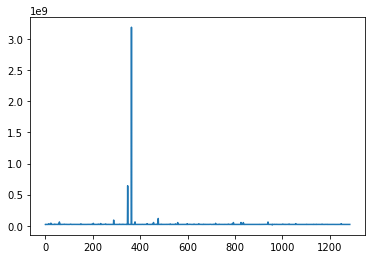

In [21]:
plt.plot(Y['TOTAL_COST'])


(array([1.18e+03, 9.00e+01, 1.10e+01, 1.00e+00, 1.00e+00, 0.00e+00,
        0.00e+00, 1.00e+00, 0.00e+00, 1.00e+00]),
 array([16.33615514, 16.8909698 , 17.44578447, 18.00059914, 18.55541381,
        19.11022847, 19.66504314, 20.21985781, 20.77467248, 21.32948714,
        21.88430181]),
 <BarContainer object of 10 artists>)

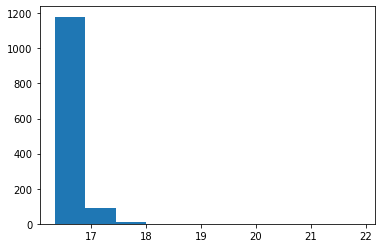

In [22]:
lig = np.log(Y['TOTAL_COST'])

# plt.plot(lig)
plt.hist(lig)

In [23]:
Y_cost_binary = lig>16.83
Y_cost_binary.value_counts()

True     666
False    619
Name: TOTAL_COST, dtype: int64

In [24]:
scaler.fit(np.array(Y['TOTAL_COST']).reshape(-1,1))
Y['TOTAL_COST']= Y_cost_binary
Y['TOTAL_COST'] = Y['TOTAL_COST'].map(lambda x: 1 if x==True else 0)

In [25]:
cost_threshold =  16.83
Y

,TOTAL_COST,INJURE_BOOL,FATAL_BOOL
0,0,1,0
1,1,0,0
2,1,0,0
3,0,0,0
4,0,1,0
...,...,...,...
1280,1,0,0
1281,1,1,0
1282,1,0,0
1283,0,0,0


In [26]:
y = pd.DataFrame(Y, columns=['TOTAL_COST','INJURE','FATAL'])

In [27]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import r2_score

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_transform,Y,train_size=0.7,random_state=123)

In [29]:
y_train

,TOTAL_COST,INJURE_BOOL,FATAL_BOOL
594,1,0,0
510,1,0,0
1106,1,1,0
176,0,0,0
620,0,0,0
...,...,...,...
1238,0,1,0
1147,0,0,0
106,1,0,0
1041,1,0,1


<AxesSubplot:xlabel='TOTAL_COST', ylabel='Count'>

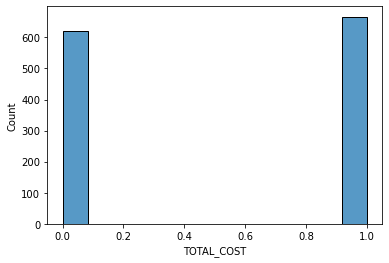

In [30]:
sns.histplot(y['TOTAL_COST'])

<AxesSubplot:xlabel='INJURE_BOOL', ylabel='Count'>

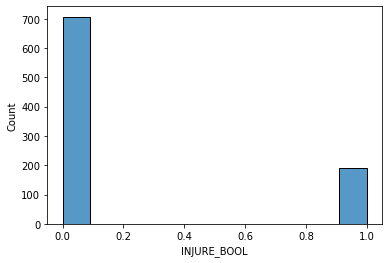

In [31]:
sns.histplot(y_train['INJURE_BOOL'])

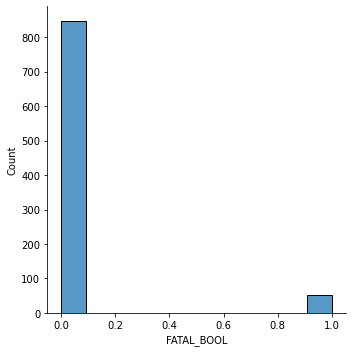

In [32]:
sns.displot(y_train['FATAL_BOOL'])

<AxesSubplot:>

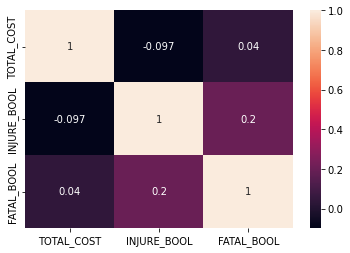

In [33]:
corr = Y.corr()
sns.heatmap(corr, annot = True)

<AxesSubplot:>

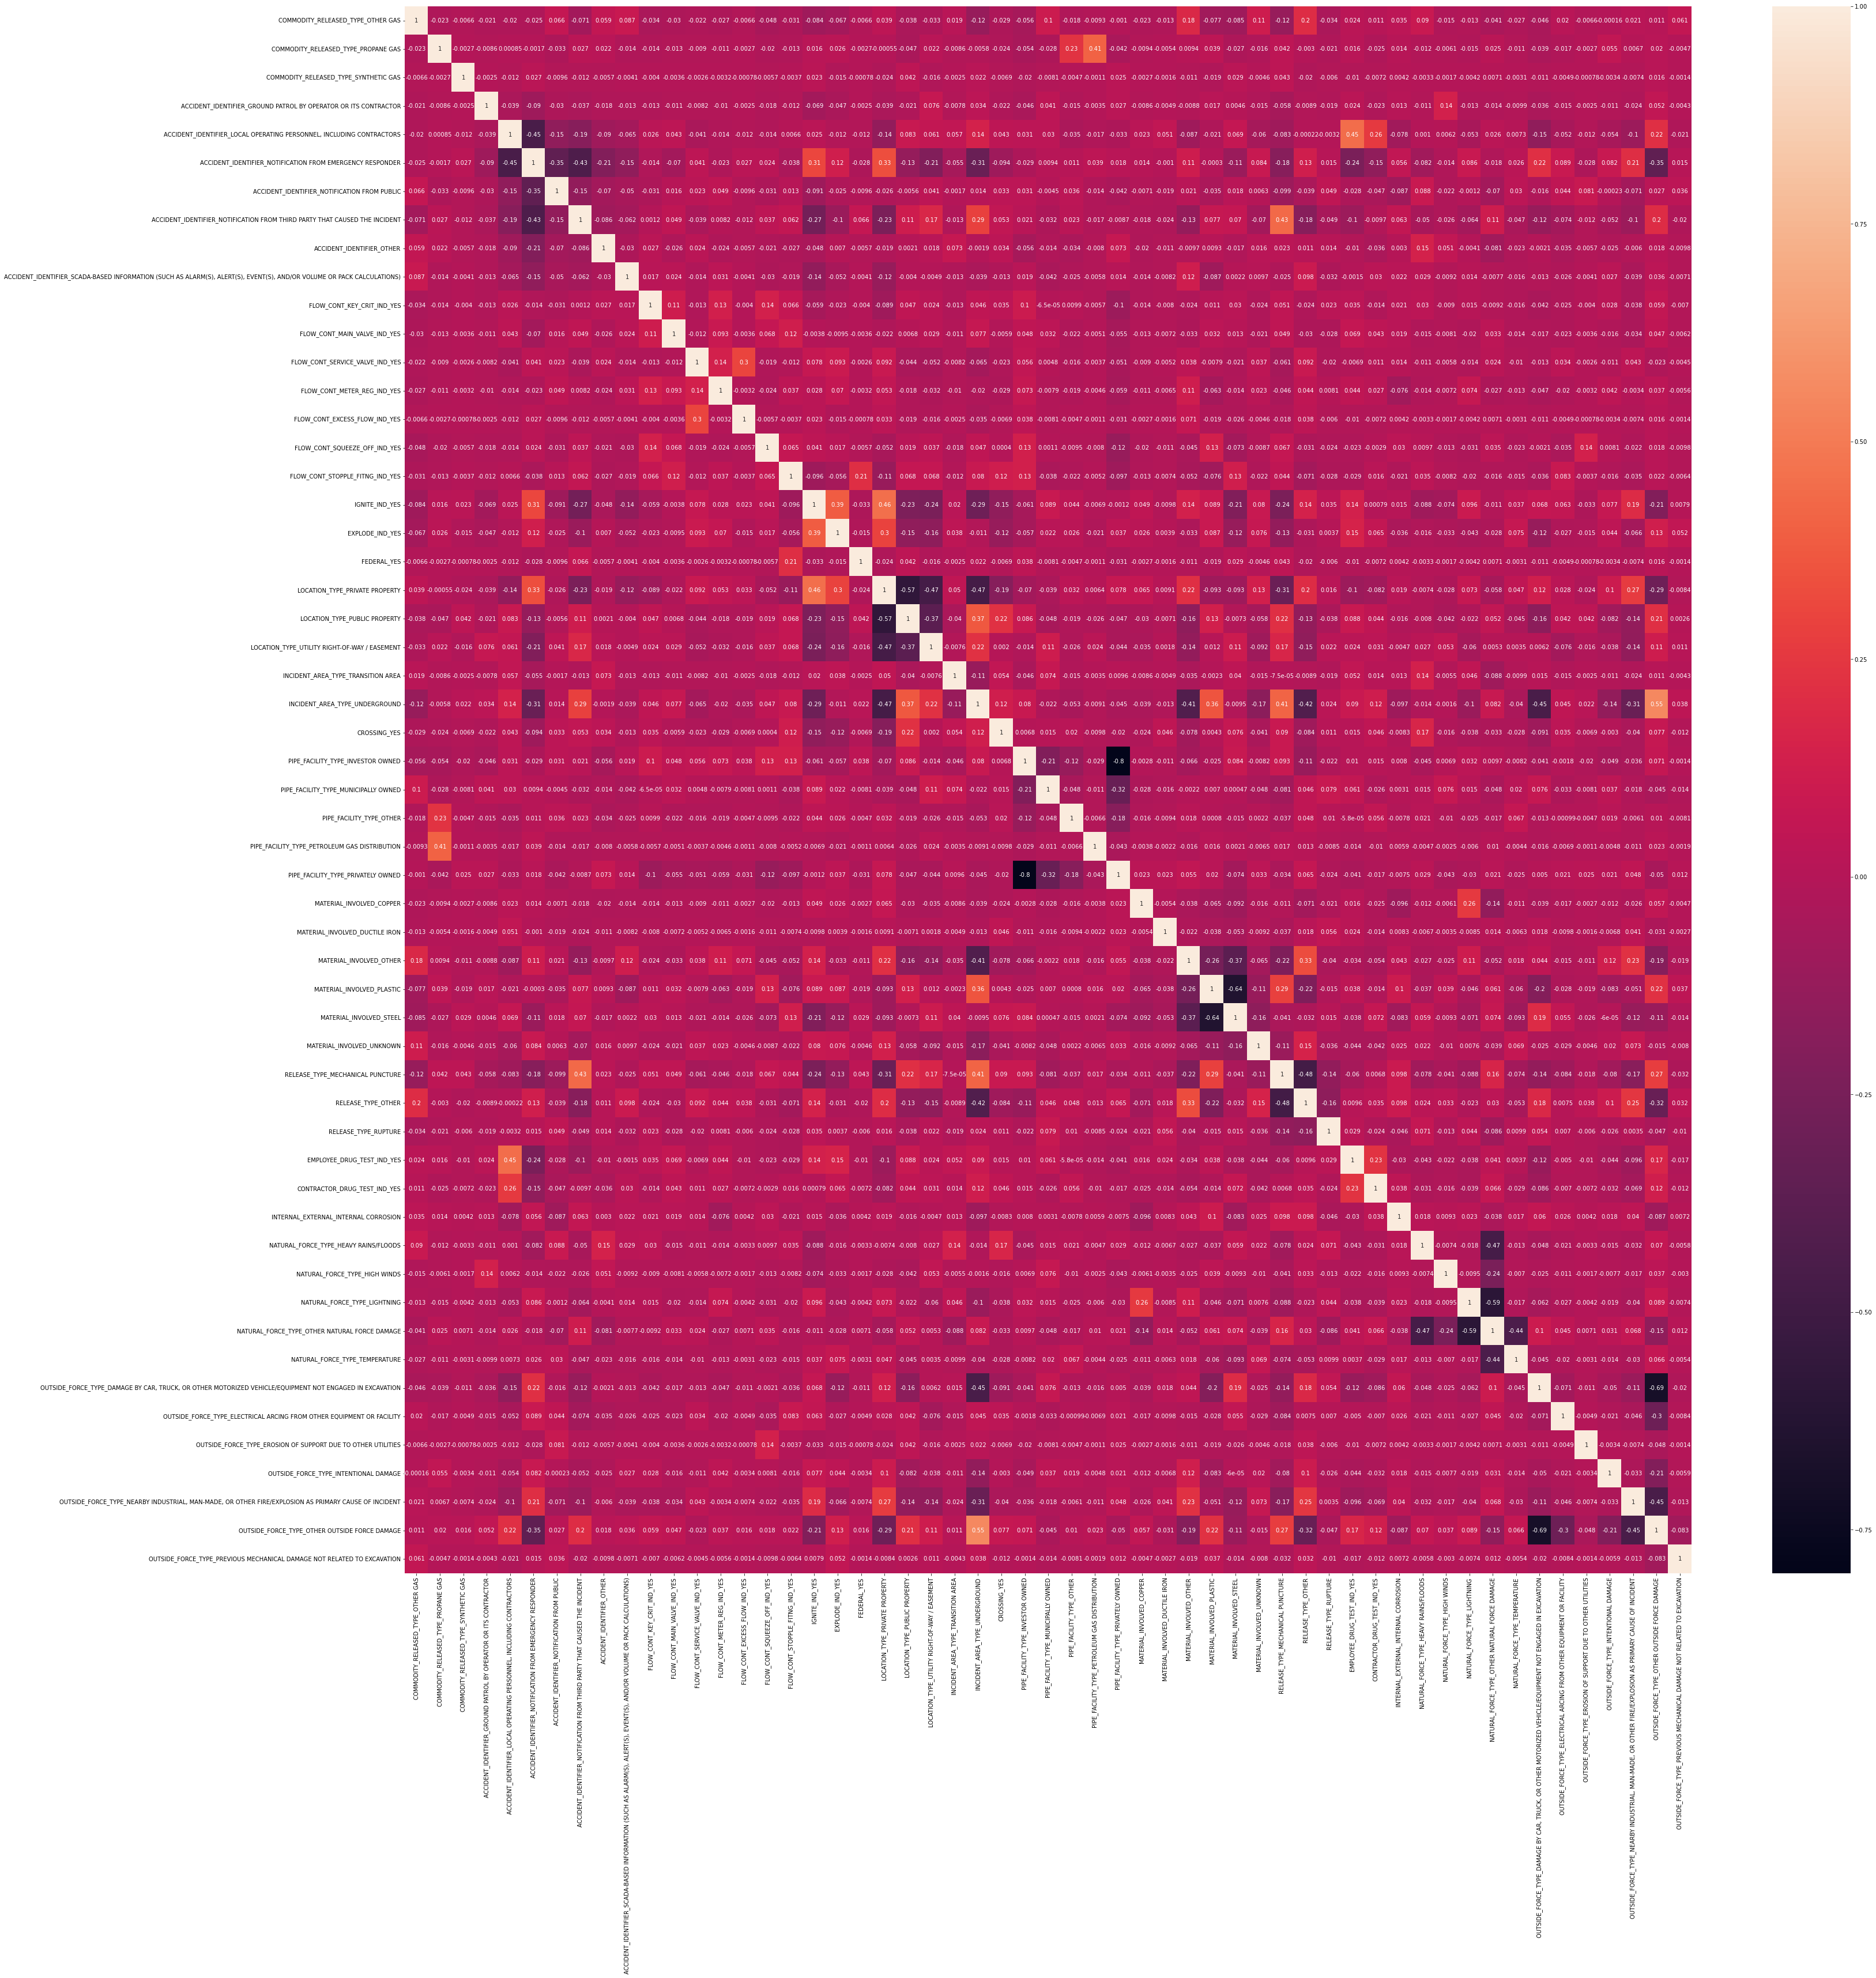

In [34]:
plt.figure(figsize=(50,50))
corr = X_transform.corr()
sns.heatmap(corr, annot = True)


In [35]:
len(Y['TOTAL_COST'].value_counts()),len(Y['INJURE_BOOL'].value_counts()),len(Y['FATAL_BOOL'].value_counts()),len(Y)

(2, 2, 2, 1285)

### TOTAL COST PREDICTION

In [36]:
# Random Forest

max_depth=[2,4,8,16,32,64]
ntrees = [4,8,16,32]
max_features = [0.1,0.2,0.3,0.5,0.9]

weights = np.linspace(0.05, 0.95, 20)
gsc = GridSearchCV(
    estimator=RandomForestClassifier(random_state = 123,class_weight='balanced'),
    param_grid={'max_depth':max_depth, 'n_estimators':ntrees,'max_features':max_features},
    scoring='f1',
    cv=5
)

oversample = SMOTE()
inp, out = oversample.fit_resample(X_train,y_train['TOTAL_COST'])

grid_result = gsc.fit(inp, out)
print("Best parameters : %s" % grid_result.best_params_)

Best parameters : {'max_depth': 8, 'max_features': 0.3, 'n_estimators': 32}


In [37]:
inp.shape, out.value_counts()

((918, 55),
 0    459
 1    459
 Name: TOTAL_COST, dtype: int64)

In [38]:
y_pred = grid_result.predict(X_test)

y_true = y_test['TOTAL_COST']

print(metrics.classification_report(y_true,y_pred))
print('Accuracy:',metrics.accuracy_score(y_true,y_pred))
print(metrics.confusion_matrix(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.65      0.74      0.69       179
           1       0.75      0.66      0.70       207

    accuracy                           0.70       386
   macro avg       0.70      0.70      0.70       386
weighted avg       0.70      0.70      0.70       386

Accuracy: 0.6968911917098446
[[133  46]
 [ 71 136]]


In [39]:
#  Decision Tree
pram_dict = {'criterion' : ['gini','entropy'],
             'max_depth': [2,4,6,8,10],
             'min_samples_split' : [2,4,6,8,10],
             'min_samples_leaf' : range(1,5)}

weights = np.linspace(0.05, 0.95, 20)
gsc = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state = 123,class_weight='balanced'),
    param_grid=pram_dict,
    scoring='f1',
    cv=5
)

oversample = SMOTE()

inp, out = oversample.fit_resample(X_train,y_train['TOTAL_COST'])

grid_result = gsc.fit(inp, out)
print("Best parameters : %s" % grid_result.best_params_)

Best parameters : {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [40]:
y_pred = grid_result.predict(X_test)

y_true = y_test['TOTAL_COST']

print(metrics.classification_report(y_true,y_pred))
print('Accuracy:',metrics.accuracy_score(y_true,y_pred))
print(metrics.confusion_matrix(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.66      0.68      0.67       179
           1       0.71      0.70      0.70       207

    accuracy                           0.69       386
   macro avg       0.69      0.69      0.69       386
weighted avg       0.69      0.69      0.69       386

Accuracy: 0.6865284974093264
[[121  58]
 [ 63 144]]


In [41]:
 # Gradient boost

pram_dict = {'learning_rate':[0.1,0.05,0.01,0.005,0.001], 'n_estimators':[100,500,1000,1500]}

weights = np.linspace(0.05, 0.95, 20)
gsc = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state = 123),
    param_grid=pram_dict,
    scoring='f1',
    cv=5
)

oversample = SMOTE()
inp, out = oversample.fit_resample(X_train,y_train['TOTAL_COST'])

grid_result = gsc.fit(inp, out)
print("Best parameters : %s" % grid_result.best_params_)

Best parameters : {'learning_rate': 0.005, 'n_estimators': 500}


In [42]:
y_pred = grid_result.predict(X_test)

y_true = y_test['TOTAL_COST']

print(metrics.classification_report(y_true,y_pred))
print('Accuracy:',metrics.accuracy_score(y_true,y_pred))
print(metrics.confusion_matrix(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.69      0.68       179
           1       0.73      0.71      0.72       207

    accuracy                           0.70       386
   macro avg       0.70      0.70      0.70       386
weighted avg       0.70      0.70      0.70       386

Accuracy: 0.6994818652849741
[[124  55]
 [ 61 146]]


# INJURIES PREDICTION

In [43]:
# Random Forest

max_depth=[2,4,8,16,32,64]
ntrees = [4,8,16,32]
max_features = [0.1,0.2,0.3,0.5,0.9]

weights = np.linspace(0.05, 0.95, 20)
gsc = GridSearchCV(
    estimator=RandomForestClassifier(random_state = 123,class_weight='balanced'),
    param_grid={'max_depth':max_depth, 'n_estimators':ntrees,'max_features':max_features},
    scoring='f1',
    cv=5
)



oversample = SMOTE()
inp, out = oversample.fit_resample(X_train,y_train['INJURE_BOOL'])

grid_result = gsc.fit(inp, out)
print("Best parameters : %s" % grid_result.best_params_)

KeyboardInterrupt: 

In [0]:
inp.shape, out.value_counts()

In [0]:
y_pred = grid_result.predict(X_test)

print(metrics.classification_report(y_test['INJURE_BOOL'],y_pred))
print('Accuracy:',metrics.accuracy_score(y_test['INJURE_BOOL'],y_pred))
print(metrics.confusion_matrix(y_test['INJURE_BOOL'],y_pred))

In [0]:
#  Decision Tree
pram_dict = {'criterion' : ['gini','entropy'],
             'max_depth': [2,4,6,8,10],
             'min_samples_split' : [2,4,6,8,10],
             'min_samples_leaf' : range(1,5)}

weights = np.linspace(0.05, 0.95, 20)
gsc = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state = 123,class_weight='balanced'),
    param_grid=pram_dict,
    scoring='f1',
    cv=5
)

oversample = SMOTE()

inp, out = oversample.fit_resample(X_train,y_train['INJURE_BOOL'])

grid_result = gsc.fit(inp, out)
print("Best parameters : %s" % grid_result.best_params_)

In [0]:
y_pred = grid_result.predict(X_test)

print(metrics.classification_report(y_test['INJURE_BOOL'],y_pred))
print('Accuracy:',metrics.accuracy_score(y_test['INJURE_BOOL'],y_pred))
print(metrics.confusion_matrix(y_test['INJURE_BOOL'],y_pred))

In [0]:
# Gradient boost

pram_dict = {'learning_rate':[0.1,0.05,0.01,0.005,0.001], 'n_estimators':[100,500,1000,1500]}

weights = np.linspace(0.05, 0.95, 20)
gsc = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state = 123),
    param_grid=pram_dict,
    scoring='f1',
    cv=5
)

oversample = SMOTE()
inp, out = oversample.fit_resample(X_train,y_train['INJURE_BOOL'])

grid_result = gsc.fit(inp, out)
print("Best parameters : %s" % grid_result.best_params_)

In [0]:
y_pred = grid_result.predict(X_test)

print(metrics.classification_report(y_test['INJURE_BOOL'],y_pred))
print('Accuracy:',metrics.accuracy_score(y_test['INJURE_BOOL'],y_pred))
print(metrics.confusion_matrix(y_test['INJURE_BOOL'],y_pred))

# FATALITIES PREDICTION

In [0]:
# Random Forest

max_depth=[2,4,8,16,32,64]
ntrees = [4,8,16,32]
max_features = [0.1,0.2,0.3,0.5,0.9]

weights = np.linspace(0.05, 0.95, 20)
gsc = GridSearchCV(
    estimator=RandomForestClassifier(random_state = 123,class_weight='balanced'),
    param_grid={'max_depth':max_depth, 'n_estimators':ntrees,'max_features':max_features},
    scoring='f1',
    cv=5
)



oversample = SMOTE()
inp, out = oversample.fit_resample(X_train,y_train['FATAL_BOOL'])

grid_result = gsc.fit(inp, out)
print("Best parameters : %s" % grid_result.best_params_)

In [0]:
y_pred = grid_result.predict(X_test)

print(metrics.classification_report(y_test['FATAL_BOOL'],y_pred))
print('Accuracy:',metrics.accuracy_score(y_test['FATAL_BOOL'],y_pred))
print(metrics.confusion_matrix(y_test['FATAL_BOOL'],y_pred))

In [0]:
#  Decision Tree
pram_dict = {'criterion' : ['gini','entropy'],
             'max_depth': [2,4,6,8,10],
             'min_samples_split' : [2,4,6,8,10],
             'min_samples_leaf' : range(1,5)}

weights = np.linspace(0.05, 0.95, 20)
gsc = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state = 123,class_weight='balanced'),
    param_grid=pram_dict,
    scoring='f1',
    cv=5
)pip install pgmpyp

oversample = SMOTE()

inp, out = oversample.fit_resample(X_train,y_train['FATAL_BOOL'])

grid_result = gsc.fit(inp, out)
print("Best parameters : %s" % grid_result.best_params_)

In [0]:
y_pred = grid_result.predict(X_test)

print(metrics.classification_report(y_test['FATAL_BOOL'],y_pred))
print('Accuracy:',metrics.accuracy_score(y_test['FATAL_BOOL'],y_pred))
print(metrics.confusion_matrix(y_test['FATAL_BOOL'],y_pred))

In [0]:
# Gradient boost

pram_dict = {'learning_rate':[0.1,0.05,0.01,0.005,0.001], 'n_estimators':[100,500,1000,1500]}

weights = np.linspace(0.05, 0.95, 20)
gsc = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state = 123),
    param_grid=pram_dict,
    scoring='f1',
    cv=5
)


oversample = SMOTE()
inp, out = oversample.fit_resample(X_train,y_train['FATAL_BOOL'])

grid_result = gsc.fit(inp, out)
print("Best parameters : %s" % grid_result.best_params_)

In [0]:
y_pred = grid_result.predict(X_test)

print(metrics.classification_report(y_test['FATAL_BOOL'],y_pred))
print('Accuracy:',metrics.accuracy_score(y_test['FATAL_BOOL'],y_pred))
print(metrics.confusion_matrix(y_test['FATAL_BOOL'],y_pred))

In [0]:
# # import tempfile
# # from IPython.core.display import display, HTML

# # shap.initjs()

# def shap_deepnote_show(plot):

#     tmp_output_filename = tempfile.NamedTemporaryFile(suffix='.html').name
#     shap.save_html(tmp_output_filename, plot)

#     f = open(tmp_output_filename, "r")
#     data = f.read()
#     display(HTML(data))

In [35]:
# # from catboost import CatBoostClassifier, Pool
# model = GradientBoostingClassifier(learning_rate= 0.1, n_estimators= 1500,random_state = 123)
# model.fit(inp, out)
# explainer = shap.Explainer(model)
# shap_values = explainer(X_train)
# shap_deepnote_show(shap.force_plot(explainer.expected_value, shap_values[10], X_test.iloc[10].values))

# shap_values = model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features) ,
#                                                type="ShapValues")
 
# expected_value = shap_values[0,-1]
# shap_values = shap_values[:,:-1]

# shap.initjs()
# shap.force_plot(expected_value, shap_values[0,:], X_test.iloc[0,:])